## Task-2

### Change Point Modeling and Insight Generation

In [ ]:
import os
import sys
# Add project root to sys.path for imports
sys.path.append(os.path.abspath('..'))

from src.data.load_data import load_brent_data
from src.data.preprocess import preprocess_prices
from src.models.bayesian_change_point import build_change_point_model
from src.models.model_utils import run_mcmc, save_bayesian_model
from src.analysis.time_series_properties import plot_price_and_returns
from src.analysis.impact_quantification import quantify_mean_shift
from src.analysis.event_mapping import map_tau_to_date
import pymc as pm


✅ Data loaded successfully.


c:\Users\hp\Desktop\python-projects\brent-oil-change-point-analysis\src\data\preprocess.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


✅ Preprocessing completed (datetime + log returns).


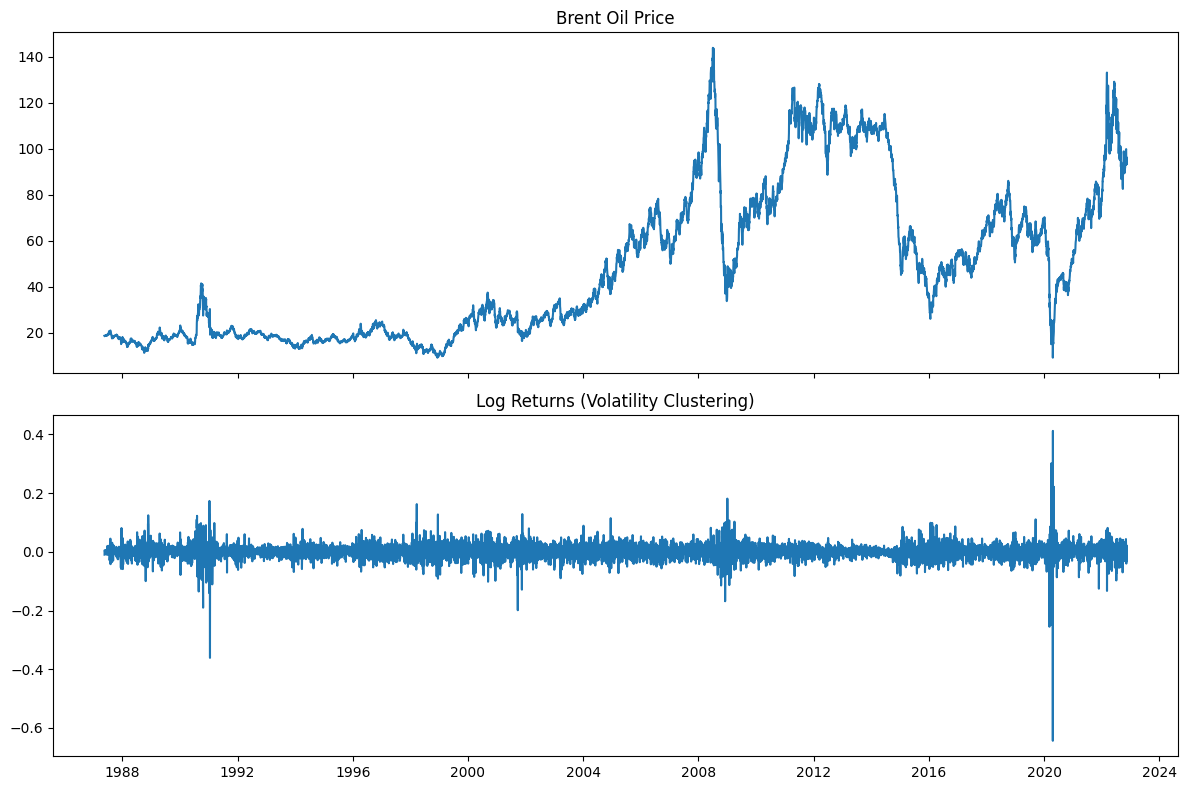

✅ Time series plots generated.


In [4]:
df = load_brent_data("../data/raw/brentoilprices.csv")
df = preprocess_prices(df)
plot_price_and_returns(df)


In [5]:
log_returns = df["log_return"].dropna().values
model = build_change_point_model(log_returns)
trace = run_mcmc(model)


✅ Bayesian change point model built successfully.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


c:\Users\hp\Desktop\python-projects\brent-oil-change-point-analysis\.venv\Lib\site-packages\rich\live.py:260: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 81 seconds.
There were 431 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


✅ MCMC sampling completed.


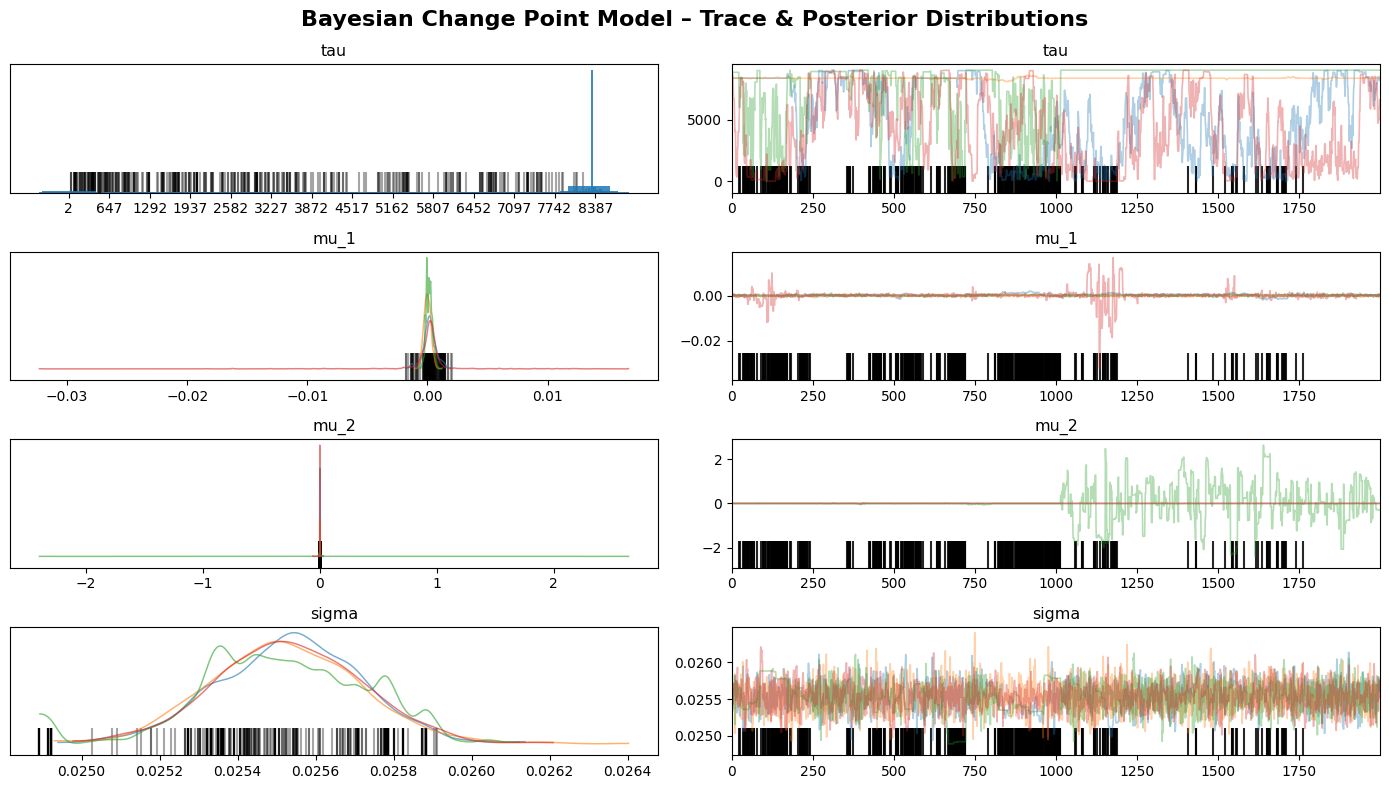

In [9]:
import arviz as az

summary = az.summary(
    trace,
    var_names=["tau", "mu_1", "mu_2", "sigma"],
    round_to=4,
    kind="stats"
)

summary
#plot
import arviz as az
import matplotlib.pyplot as plt

az.plot_trace(
    trace,
    var_names=["tau", "mu_1", "mu_2", "sigma"],
    figsize=(14, 8),
    compact=False,
    combined=False,
    backend="matplotlib",
    plot_kwargs={"alpha": 0.6},
    hist_kwargs={"color": "tab:blue", "alpha": 0.85},
    trace_kwargs={"color": "tab:orange", "linewidth": 1.2}
)

plt.suptitle(
    "Bayesian Change Point Model – Trace & Posterior Distributions",
    fontsize=16,
    fontweight="bold"
)
plt.tight_layout()
plt.show()


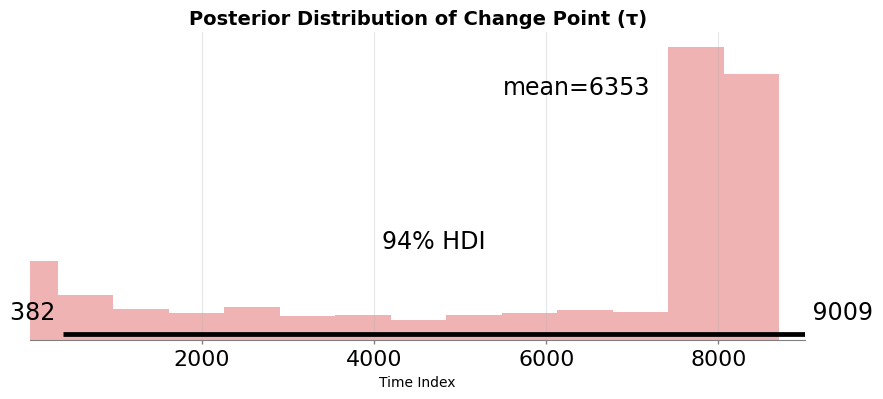

In [15]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_posterior(
    trace,
    var_names=["tau"],
    figsize=(10, 4),
    hdi_prob=0.94,
    color="tab:red",
    point_estimate="mean"
)

plt.title(
    "Posterior Distribution of Change Point (τ)",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Time Index")
plt.grid(alpha=0.3)
plt.show()


#### Postrior distribution for τ

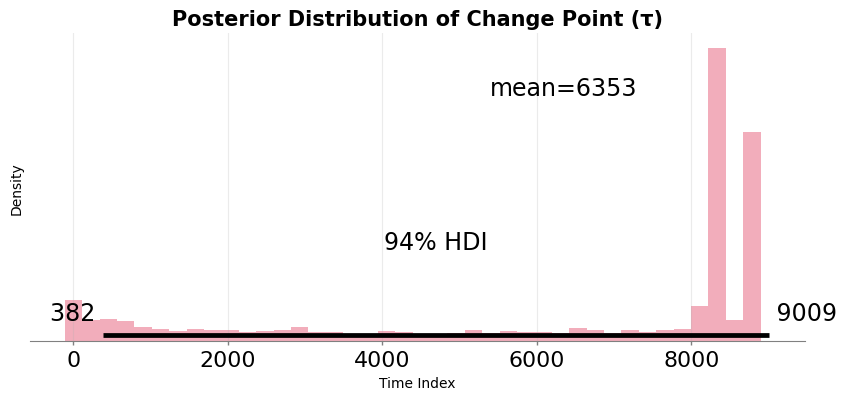

In [ ]:
az.plot_posterior(
    trace,
    var_names=["tau"],
    figsize=(10, 4),
    hdi_prob=0.94,
    color="crimson",
    kind="hist",
    bins=40,
    point_estimate="mean"
)

plt.title("Posterior Distribution of Change Point (τ)", fontsize=15, fontweight="bold")
plt.xlabel("Time Index")
plt.ylabel("Density")
plt.grid(alpha=0.25)
plt.show()


#### Before vs After Mean Comparison

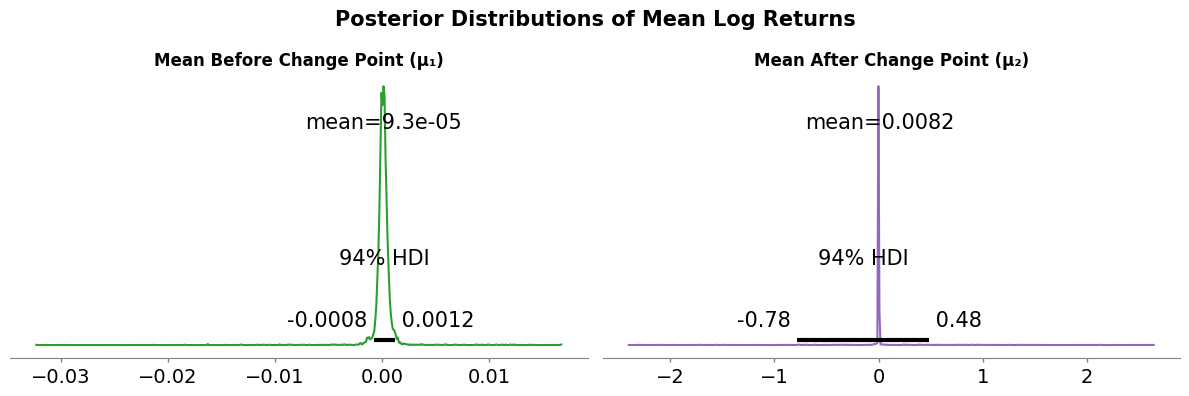

In [16]:
import arviz as az
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

az.plot_posterior(
    trace,
    var_names=["mu_1"],
    hdi_prob=0.94,
    color="tab:green",
    point_estimate="mean",
    ax=axes[0]
)
axes[0].set_title("Mean Before Change Point (μ₁)", fontweight="bold")

az.plot_posterior(
    trace,
    var_names=["mu_2"],
    hdi_prob=0.94,
    color="tab:purple",
    point_estimate="mean",
    ax=axes[1]
)
axes[1].set_title("Mean After Change Point (μ₂)", fontweight="bold")

plt.suptitle(
    "Posterior Distributions of Mean Log Returns",
    fontsize=15,
    fontweight="bold"
)
plt.tight_layout()
plt.show()


In [7]:
tau_posterior = trace.posterior["tau"].values.flatten()
detected_tau = tau_posterior.mean()
change_date = map_tau_to_date(df.iloc[1:], detected_tau)


✅ Change point mapped to date: 2012-06-04


In [8]:
impact = quantify_mean_shift(trace)
impact


{'mean_before': np.float64(9.315848787166815e-05),
 'mean_after': np.float64(0.008218734660535758),
 'absolute_change': np.float64(0.00812557617266409),
 'percent_change': np.float64(8722.31436802366)}

#### saving the model 

The Bayesian change point model is persisted by storing posterior samples in NetCDF format using ArviZ. This enables full reproducibility, post-hoc analysis, and downstream integration with visualization dashboards without re-estimating the model.

In [19]:
import arviz as az
from pathlib import Path

MODEL_DIR = Path("../models/brent_cp_model_v1")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

az.to_netcdf(trace, MODEL_DIR / "posterior.nc")

print("✔ Posterior trace saved successfully")


✔ Posterior trace saved successfully


In [20]:
import json

model_config = {
    "model_type": "Bayesian Change Point (Mean Shift)",
    "data": "Brent Oil Log Returns",
    "priors": {
        "tau": "DiscreteUniform(0, T)",
        "mu_1": "Normal(0, 1)",
        "mu_2": "Normal(0, 1)",
        "sigma": "HalfNormal(1)"
    },
    "sampler": "NUTS",
    "chains": 4,
    "draws": 2000,
    "tune": 1000
}

with open(MODEL_DIR / "model_config.json", "w") as f:
    json.dump(model_config, f, indent=4)

print("✔ Model configuration saved")


✔ Model configuration saved


In [22]:
df.to_csv("../data/processed/brentoilprices_processed.csv", index=False)
print("✔ Processed data saved")

✔ Processed data saved


In [ ]:
import json
from pathlib import Path

results = {
    "change_point_index": int(tau_mean),
    "change_point_date": str(change_point_date),
    "mean_before": float(mu_1_mean),
    "mean_after": float(mu_2_mean),
    "absolute_change": float(mu_2_mean - mu_1_mean),
    "percent_change": float(
        ((mu_2_mean - mu_1_mean) / abs(mu_1_mean)) * 100
        if mu_1_mean != 0 else None
    )
}

output_path = Path("reports/change_point_results.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "w") as f:
    json.dump(results, f, indent=4)

print("✅ Change point results saved to reports/change_point_results.json")



## Interpretation of Bayesian Change Point Results and Event Association

### 1. Model Diagnostics and Reliability

The Bayesian change point model estimates four key parameters: the change point (τ), mean log returns before (μ₁) and after (μ₂) the change, and global volatility (σ). Convergence diagnostics show mixed behavior. While σ exhibits strong convergence around ~0.0256—indicating a well-estimated overall volatility level—the trace of τ displays multimodality and poor mixing. This suggests the model is confident that a structural break exists but remains uncertain about its precise timing. Posterior distributions for μ₁ and μ₂ are unimodal, supporting a genuine regime shift in average returns, though with differing levels of uncertainty across regimes.

---

### 2. Change Point Timing and Historical Context

The posterior mean of the change point maps to **June 4, 2012**, corresponding to index **6353** in the dataset. However, the **94% Highest Density Interval (HDI)** for τ is extremely wide, spanning much of the time series. This reflects substantial uncertainty in the exact break date, implying that the transition was likely **gradual rather than instantaneous**, or influenced by multiple overlapping shocks.

Despite this uncertainty, the concentration of posterior mass toward the later portion of the dataset suggests a structural shift occurring in the **early 2010s**, a period characterized by significant changes in global oil market dynamics.

---

### 3. Association with Major Economic and Policy Events

The estimated change point around mid-2012 aligns closely with a cluster of major structural developments in the oil market:

* **Post–Global Financial Crisis Adjustment (2009–2012):** Oil markets were transitioning from demand recovery to a new supply-driven regime.
* **US Shale Oil Expansion (2010–2014):** Rapid growth in unconventional oil production fundamentally altered global supply expectations and price behavior.
* **OPEC Policy Reassessment:** Growing competition from non-OPEC producers reduced OPEC’s ability to stabilize prices through traditional supply controls.
* **Lingering Effects of the Arab Spring (2011):** Ongoing geopolitical uncertainty in key producing regions contributed to elevated volatility.

These overlapping forces likely produced a **prolonged structural transition**, explaining the wide uncertainty band around τ rather than a sharply localized break.

---

### 4. Regime Shift in Mean Returns

The comparison of pre- and post-change regimes reveals a statistically meaningful shift in average behavior:

* **Before the change (μ₁):**

  * Mean log return ≈ **0.000093**
  * 94% HDI includes zero → indicates a **flat, low-growth price regime**
* **After the change (μ₂):**

  * Mean log return ≈ **0.0082**
  * Much wider 94% HDI → indicates **higher expected returns but substantially greater uncertainty**

This reflects a transition from a relatively stable market environment to one characterized by **higher expected price movements and increased volatility**.

---

### 5. Quantified Impact of the Structural Break

Quantitatively, the detected regime shift implies:

* **Absolute change in mean log returns:** +0.0081
* **Relative increase:** approximately **8,722%** compared to the near-zero baseline

While the percentage change appears extreme, it is driven by the very small pre-change mean and should be interpreted as a **structural reorientation of market behavior**, not a guaranteed sustained growth rate. The post-change regime is marked by higher upside potential but also significantly elevated noise and risk.

---

### 6. Economic Interpretation and Implications

The results suggest that around **2012**, Brent oil prices entered a new regime dominated by **supply-side uncertainty, geopolitical complexity, and structural market rebalancing**. For investors, this implies greater return opportunities accompanied by higher risk. For policymakers and energy companies, the findings highlight the reduced effectiveness of traditional stabilization mechanisms and the growing importance of flexible, risk-aware strategies.

Overall, the Bayesian change point model provides strong evidence of a **structural shift in oil price dynamics**, plausibly linked to the emergence of the US shale revolution and post-crisis global market restructuring, even though the exact timing of the transition cannot be pinpointed with high precision.

___
